In [3]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

## Setup tickers and dates

In [ ]:
start = datetime.datetime(2015,10,1)
end = datetime.datetime(2021,9,30)
tickers = ["VOO", "VTI", "VYM", "VWO", "BSV"]

## Get the data from yahoo finance

In [8]:
returns = pd.DataFrame()

for ticker in tickers:
    data = web.DataReader(ticker, 'yahoo', start, end)
    data = pd.DataFrame(data)
    
    data[ticker] = data['Adj Close'].pct_change() # Calculate daily portfolio returns.
    
    if returns.empty:
        returns = data[[ticker]]
    else:
        returns = returns.join(data[[ticker]], how='outer')
print(returns.head())

                 VOO       VTI       VYM       VWO       BSV
Date                                                        
2015-10-01       NaN       NaN       NaN       NaN       NaN
2015-10-02  0.014472  0.014557  0.013900  0.026205  0.002366
2015-10-05  0.017958  0.018433  0.021746  0.019959 -0.001119
2015-10-06 -0.003352 -0.003228  0.000308 -0.002590  0.000249
2015-10-07  0.008382  0.009030  0.009405  0.024812 -0.000622


## Run the portfolio simulations

In [10]:
number_of_portfolios = 25000 # number of portfolios to simulate
portfolio_returns = []
portfolio_risks = []
portfolio_weights = []
sharpe_ratios = []
RF = 0 # risk factor

for portfolio in range(number_of_portfolios):
    
    # generate weights
    weights =  np.random.random_sample(len(tickers))
    weights = np.round((weights / np.sum(weights)), len(tickers)) # normalize weights to add to 1
    portfolio_weights.append(weights)
    
    # calculate annualized returns
    annualized_return = np.sum(returns.mean() * weights) * 252 # 252 are the avg trading days per year.
    portfolio_returns.append(annualized_return)
    
    # matrix covariance and portfolio risk calculation
    matrix_covariance = returns.cov() * 252
    portfolio_variance = np.dot(weights.T, np.dot(matrix_covariance, weights))
    portfolio_standard_deviation = np.sqrt(portfolio_variance)
    portfolio_risks.append(portfolio_standard_deviation)
    
    # sharpe ratio
    sharpe_ratio = (annualized_return - RF)/ portfolio_standard_deviation
    sharpe_ratios.append(sharpe_ratio)

## Build table with min risk, max return and max sharpe portfolios

In [67]:
portfolio_returns = np.array(portfolio_returns)
portfolio_risks = np.array(portfolio_risks)
sharpe_ratios = np.array(sharpe_ratios)

portfolio_metrics = pd.DataFrame([portfolio_returns, portfolio_risks, sharpe_ratios]).T
portfolio_metrics.columns = ['Return', 'Risk', 'Sharpe Ratio']
portfolio_weights_df = pd.DataFrame(portfolio_weights, columns=tickers)
portfolios_df = pd.concat([portfolio_metrics, portfolio_weights_df], axis=1)

In [68]:
min_risk = portfolios_df.iloc[portfolios_df["Risk"].astype(float).idxmin()]
max_return = portfolios_df.iloc[portfolios_df["Return"].astype(float).idxmax()]
max_sharpe = portfolios_df.iloc[portfolios_df["Sharpe Ratio"].astype(float).idxmax()]

In [69]:
main_portfolios = pd.concat([min_risk,max_return,max_sharpe], axis=1).T
main_portfolios.index = ['Min Risk', 'Max Return', 'Max Sharpe']
main_portfolios

,Return,Risk,Sharpe Ratio,VOO,VTI,VYM,VWO,BSV
Min Risk,0.048413,0.036381,1.330744,0.17166,0.00270,0.00260,0.01194,0.81110
Max Return,0.167169,0.182046,0.918277,0.38903,0.54109,0.05895,0.00789,0.00303
Max Sharpe,0.048413,0.036381,1.330744,0.17166,0.00270,0.00260,0.01194,0.81110


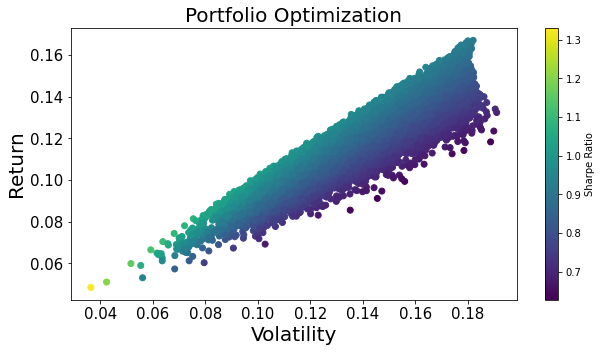

In [70]:
# Visualization

plt.figure(figsize=(10, 5))
plt.scatter(portfolio_risks, portfolio_returns, c=portfolio_returns/portfolio_risks)
plt.title('Portfolio Optimization', fontsize=20)
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Return', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.colorbar(label='Sharpe Ratio')
plt.show()